# Test DRDV Policy  with Engine Failure

In [1]:
import numpy as np
import os,sys



sys.path.append('../../../RL_lib/Agents/PPO')
sys.path.append('../../../RL_lib/Utils')
sys.path.append('../../../Mars3dof_env')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/RL_Meta-Learning-master/Experiments/Mars3DOF/Baseline


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

3-dof dynamics model
lander model apf
queue fixed
Flat Constraint


<IPython.core.display.Javascript object>


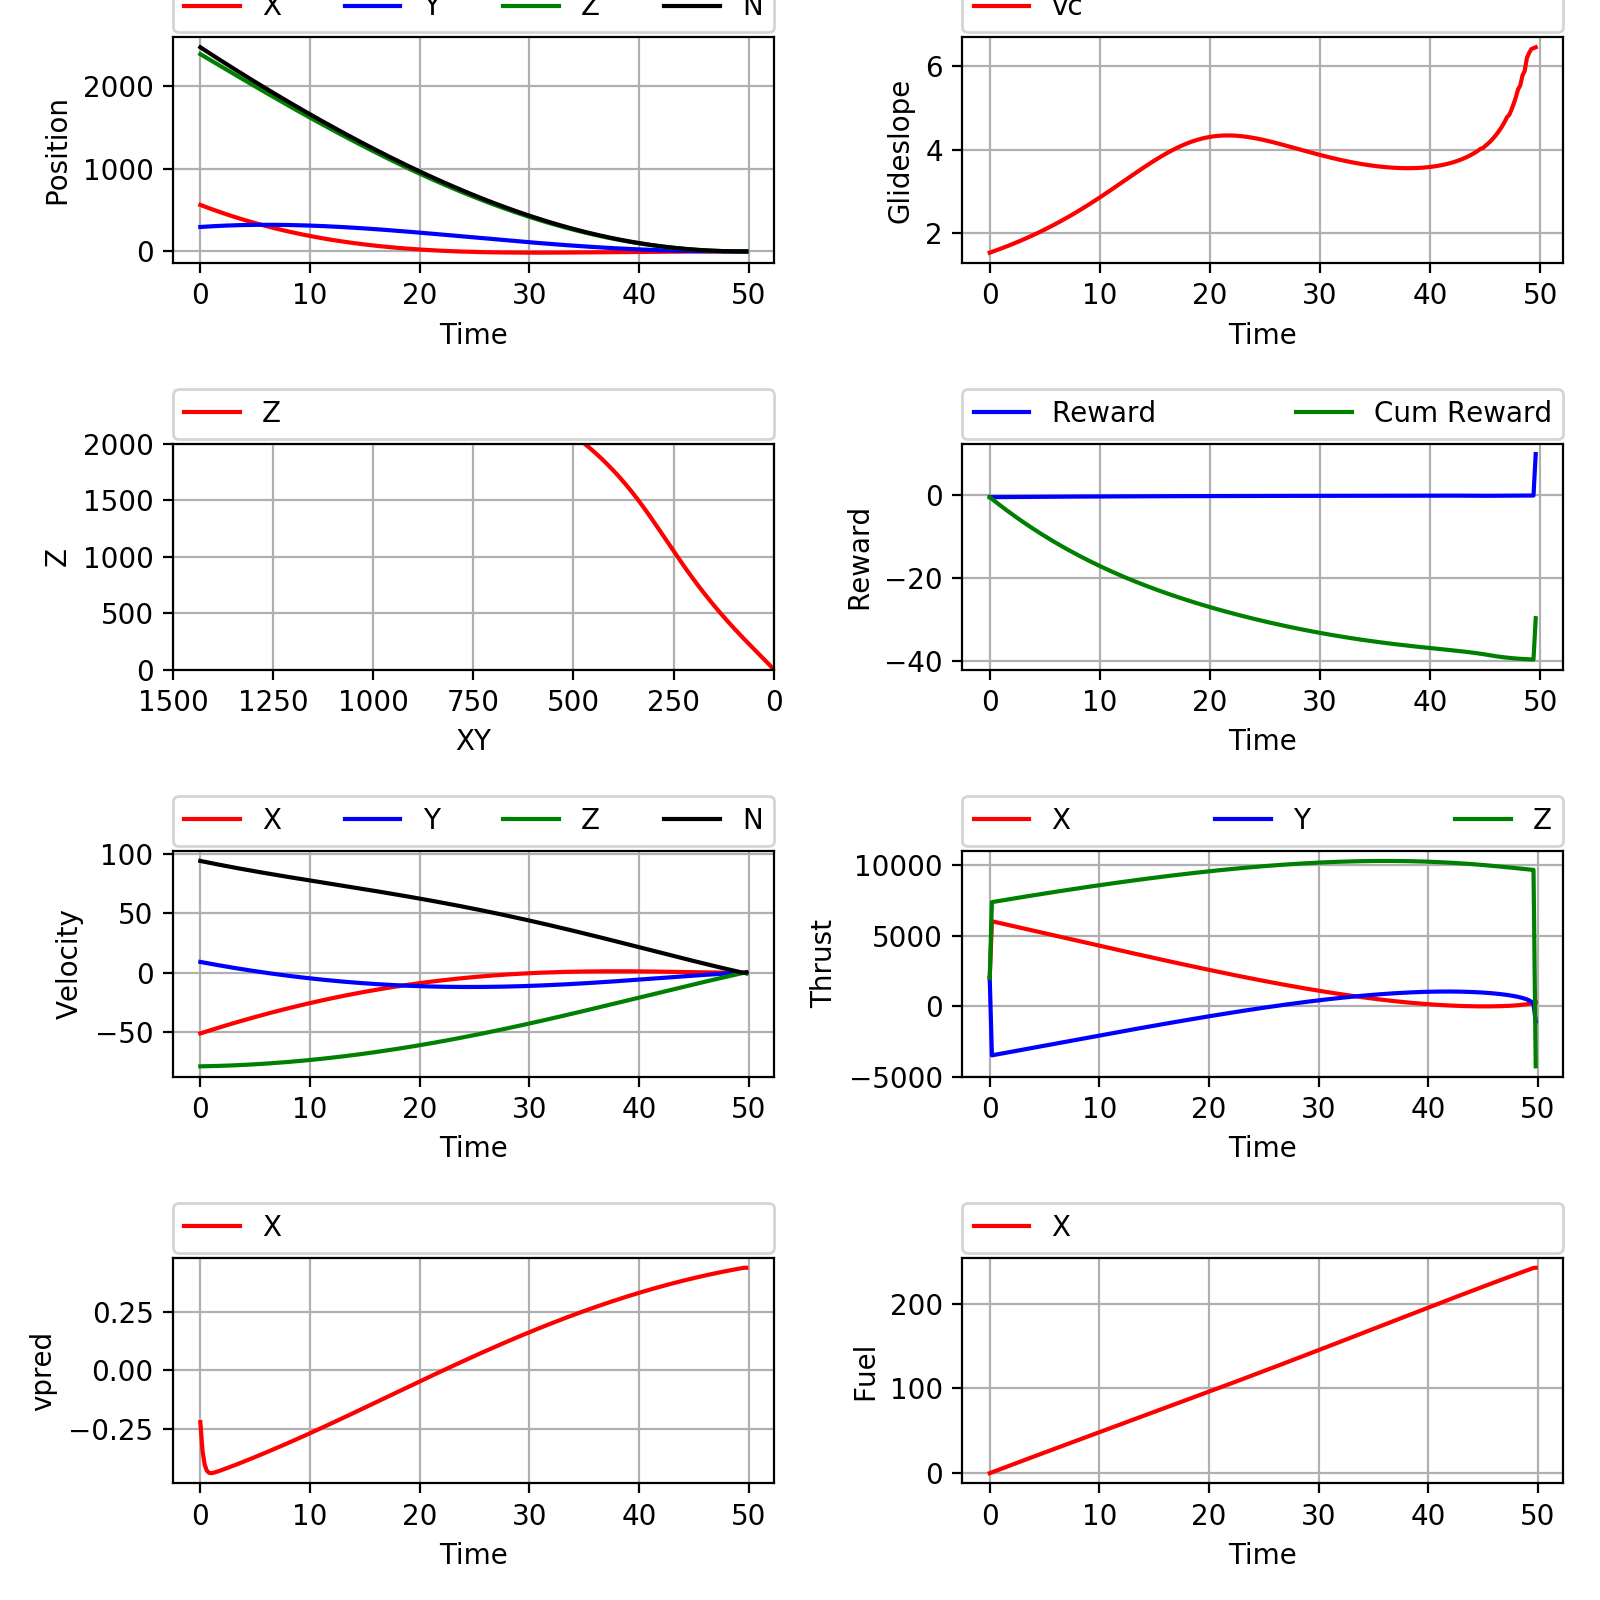

<IPython.core.display.Javascript object>


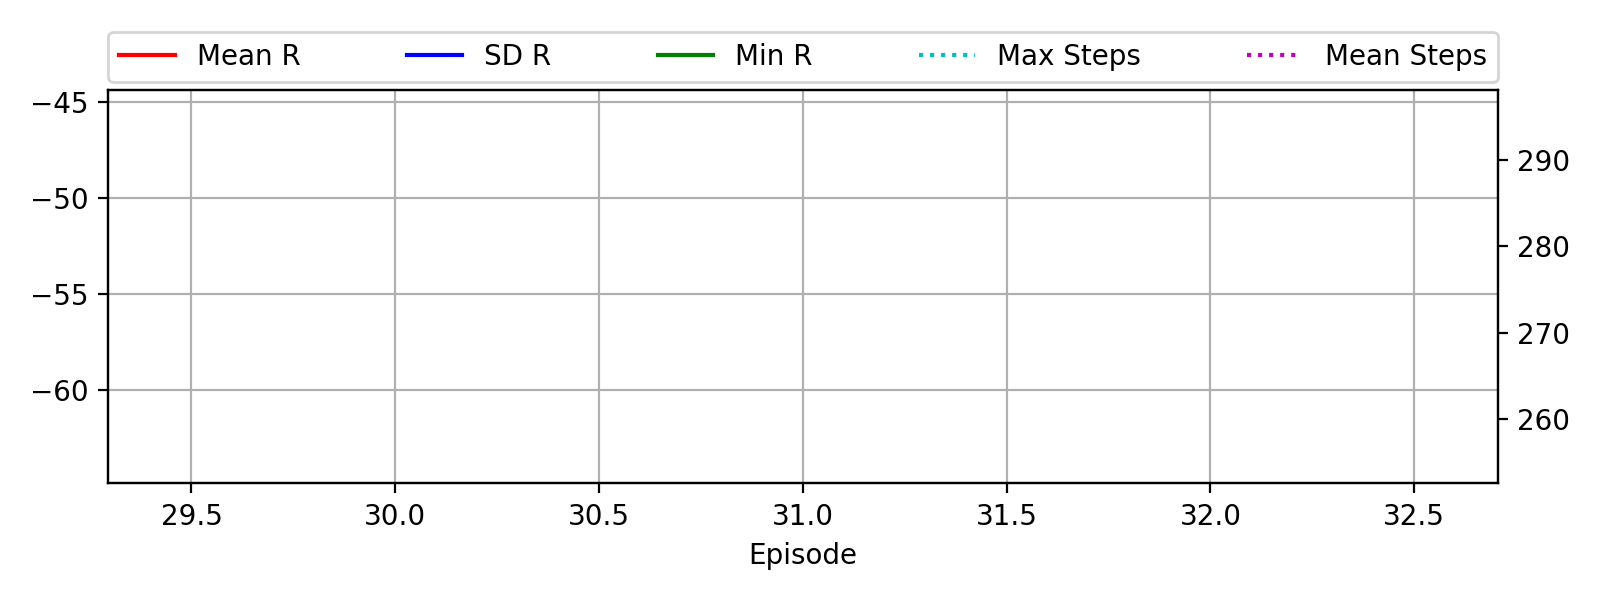

<IPython.core.display.Javascript object>


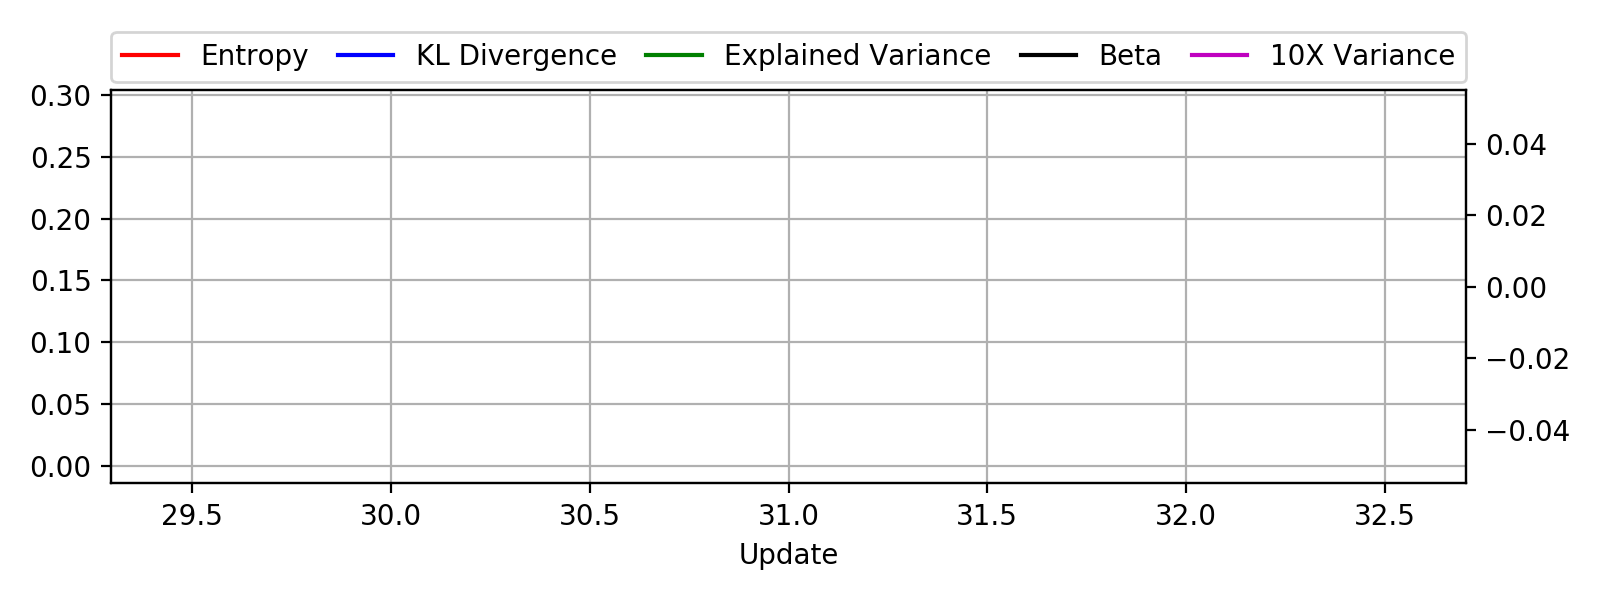

<IPython.core.display.Javascript object>


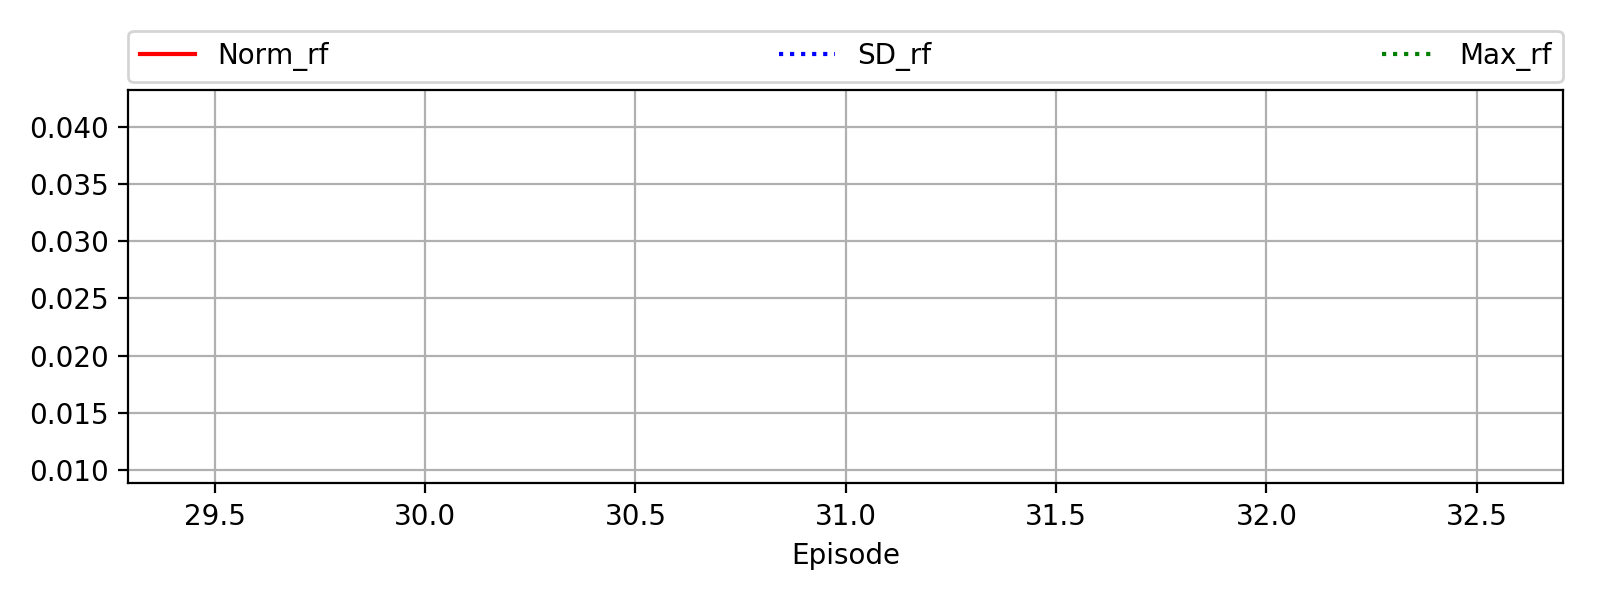

<IPython.core.display.Javascript object>


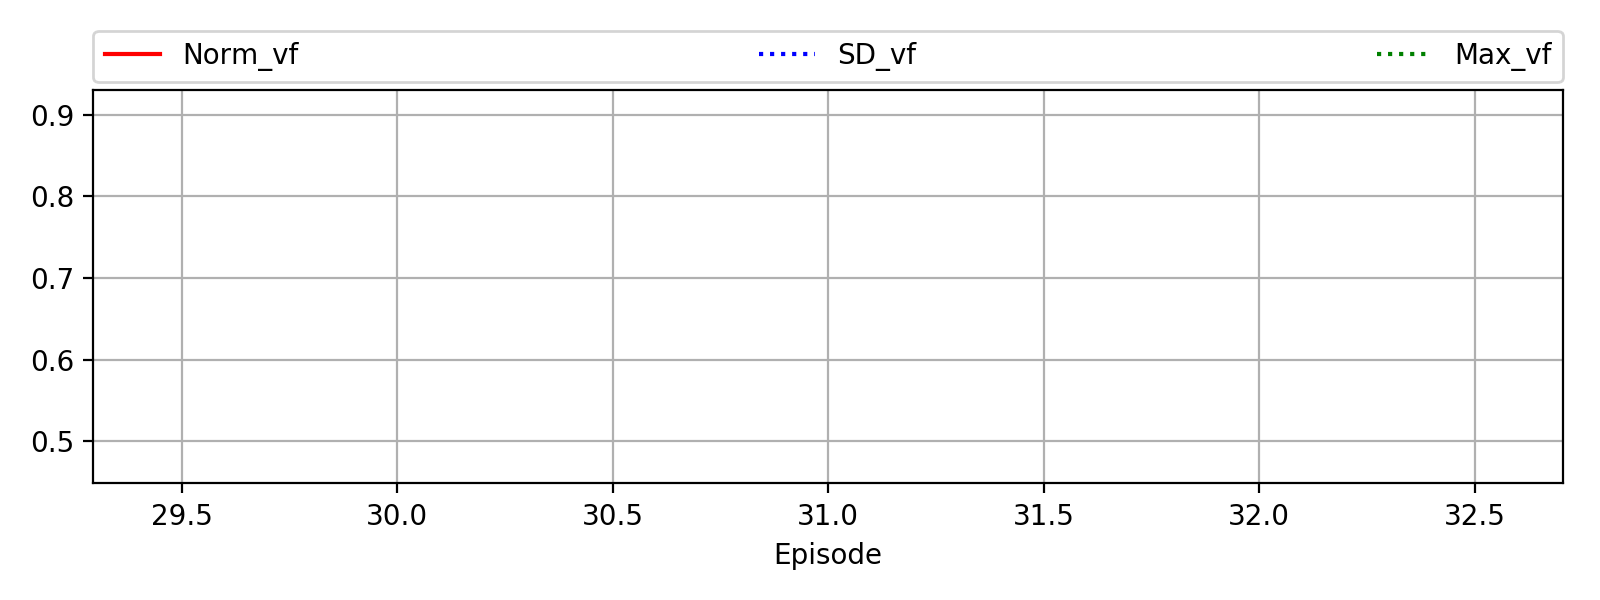

Lander Env
Landing_icgen:
    nominal_g                   :  -3.7114
    downrange                   :  (0, 2000, -70, -10)
    crossrange                  :  (-1000, 1000, -30, 30)
    altitude                    :  (2300, 2400, -90, -70)
    adjust_apf_v0               :  True
Value Funtion
	xn_init: layer  Linear(in_features=6, out_features=60, bias=True)
	xn_init: layer  GRUCell(60, 17)
	xn_init: layer  Linear(in_features=17, out_features=5, bias=True)
	xn_init: layer  Linear(in_features=5, out_features=1, bias=True)
Value Function: recurrent steps > 1, disabling shuffle and batching
	Clip Range:         0.5
	Shuffle :           False
	Batch Size :        9999999
	Max Grad Norm:      30
	Recurrent Steps:    20
	Rollout Limit:      1
Agent
*** SCALER WARMUP COMPLETE *** 
ValFun  Gradients: u/sd/Max/C Max/Max u/Max sd :   0.1613   0.1287   0.5659   0.5659   0.1613   0.1287
Update Cnt = 0    ET =     28.1   Stats:  Mean, Std, Min, Max
r_f      |    -0.0     0.0    -0.0 |     0.0     0

In [3]:
from env import Env
import env_utils as envu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen2 import Landing_icgen
import rl_utils

from arch_policy_vf import Arch


from policy_drdv import Policy
from value_function import Value_function


import policy_nets as policy_nets
import valfunc_nets as valfunc_nets

from agent import Agent


import torch.nn as nn

from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from reward_terminal_mdr import Reward


logger = rl_utils.Logger()
dynamics_model = Dynamics_model()
lander_model = Lander_model(apf_tau1=20,apf_tau2=100,apf_vf1=-2,apf_vf2=-1,apf_v0=70,apf_atarg=15.)
lander_model.get_state_agent = lander_model.get_state_agent1

obs_dim = 6
act_dim = 3
recurrent_steps = 20

reward_object = Reward()

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          tf_limit=100.0,print_every=10)

env.ic_gen = Landing_icgen(mass_uncertainty=0.05, 
                           g_uncertainty=(0.05,0.05),
                           adjust_apf_v0=True,
                          downrange = (0,2000 , -70, -10), 
                           crossrange = (-1000,1000 , -30,30),  
                           altitude = (2300,2400,-90,-70))
env.ic_gen.show()

arch = Arch()

policy = Policy(env)
value_function = Value_function(valfunc_nets.GRU(obs_dim, recurrent_steps=recurrent_steps), 
                                shuffle=False, batch_size=9999999, max_grad_norm=30)

agent = Agent(arch, policy, value_function, None, env, logger,
              policy_episodes=30, policy_steps=3000, gamma1=0.95, gamma2=0.995, lam=0.98, 
              recurrent_steps=recurrent_steps, monitor=env.rl_stats)
agent.train(3)

# Test Policy 

In [4]:
policy.test_mode=True

env.test_policy_batch(agent,5000,print_every=100)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |10361.61 |1052.91 |2106.29 |15000.00 |    63
glideslope | 2.352 | 1.904 | 0.693 |45.027 |    94
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.538 |   0.249 |   0.002 |   1.003
norm_rf  |     0.0 |     0.0 |     0.0 |     0.0
position |    -0.0     0.0    -0.0 |     0.0     0.0     0.0 |    -0.0    -0.0    -0.0 |     0.0     0.0    -0.0
velocity |  -0.066   0.004  -0.507 |   0.137   0.116   0.240 |  -0.909  -0.418  -0.928 |   0.202   0.460  -0.001
fuel     |253.47 | 13.95 |223.81 |294.28
glideslope |  3.44 |  2.92 |  0.99 | 16.61
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |10363.09 |1084.10 |2106.29 |15000.00 |    63
glideslope | 2.383 | 2.861 | 0.620 |212.801 |   103
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.538 |   0.261 |   0.002 |   1.003
norm_rf  |     0.0 |     0.0 |     0.0 |     0.0
position |    -

i :  1400
Cumulative Stats (mean,std,max,argmax)
thrust   |10318.03 |1062.57 |2000.00 |15000.00 |   263
glideslope | 2.345 | 2.837 | 0.507 |212.801 |   103
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.522 |   0.243 |   0.001 |   1.003
norm_rf  |     0.0 |     0.0 |     0.0 |     0.1
position |    -0.0     0.0    -0.0 |     0.0     0.0     0.0 |    -0.0    -0.0    -0.0 |     0.0     0.0    -0.0
velocity |  -0.063   0.002  -0.488 |   0.135   0.121   0.238 |  -0.916  -0.660  -0.928 |   0.636   0.577   0.013
fuel     |255.02 | 15.07 |220.14 |306.25
glideslope |  3.28 |  3.82 |  0.82 | 65.03
i :  1500
Cumulative Stats (mean,std,max,argmax)
thrust   |10317.85 |1061.07 |2000.00 |15000.00 |   263
glideslope | 2.327 | 2.776 | 0.507 |212.801 |   103
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.521 |   0.243 |   0.001 |   1.003
norm_rf  |     0.0 |     0.0 |     0.0 |     0.1
position |  

i :  2700
Cumulative Stats (mean,std,max,argmax)
thrust   |10325.14 |1057.66 |2000.00 |15000.00 |  1684
glideslope | 2.376 | 5.947 | 0.477 |4219.722 |  2325
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.522 |   0.242 |   0.001 |   1.003
norm_rf  |     0.0 |     0.0 |     0.0 |     0.1
position |    -0.0     0.0    -0.0 |     0.0     0.0     0.0 |    -0.1    -0.1    -0.0 |     0.1     0.0    -0.0
velocity |  -0.058   0.003  -0.489 |   0.129   0.124   0.238 |  -0.916  -0.865  -0.928 |   0.636   0.859   0.013
fuel     |255.20 | 15.11 |220.14 |317.83
glideslope |  3.38 |  4.72 |  0.77 |137.53
i :  2800
Cumulative Stats (mean,std,max,argmax)
thrust   |10324.48 |1058.55 |2000.00 |15000.00 |  1684
glideslope | 2.382 | 5.875 | 0.477 |4219.722 |  2325
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.524 |   0.242 |   0.001 |   1.003
norm_rf  |     0.0 |     0.0 |     0.0 |     0.1
position |

i :  4000
Cumulative Stats (mean,std,max,argmax)
thrust   |10321.94 |1058.74 |2000.00 |15000.00 |  1684
glideslope | 2.364 | 5.120 | 0.430 |4219.722 |  2325
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.525 |   0.243 |   0.000 |   1.003
norm_rf  |     0.0 |     0.0 |     0.0 |     0.1
position |    -0.0     0.0    -0.0 |     0.0     0.0     0.0 |    -0.1    -0.1    -0.0 |     0.1     0.1    -0.0
velocity |  -0.056   0.003  -0.491 |   0.130   0.127   0.238 |  -0.916  -0.865  -0.928 |   0.879   0.910   0.013
fuel     |255.30 | 15.21 |220.14 |320.33
glideslope |  3.34 |  4.40 |  0.77 |137.53
i :  4100
Cumulative Stats (mean,std,max,argmax)
thrust   |10324.20 |1059.15 |2000.00 |15000.00 |  1684
glideslope | 2.362 | 5.066 | 0.430 |4219.722 |  2325
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.524 |   0.243 |   0.000 |   1.003
norm_rf  |     0.0 |     0.0 |     0.0 |     0.1
position |